###  Localization and computes DICE coefficients using entire training set and is being tested on a testing set

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

######Load the Images

test_imgs=[]
test_gray=[]

#prepare directory
directory = "./test_images/"
load_img = sorted(os.listdir(directory))


# load the images
img_length =len(load_img)
for i in range(img_length):
    img = cv2.imread(directory + load_img[i])    
    test_imgs.append(img)


# convert the images to gray    
for i in range(len(test_imgs)):
    img_gray = cv2.cvtColor(test_imgs[i], cv2.COLOR_BGR2GRAY)
    test_gray.append(img_gray)
   

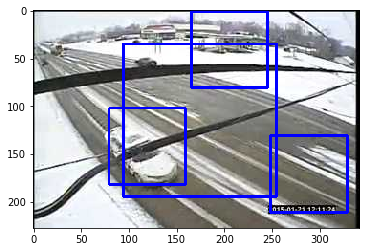

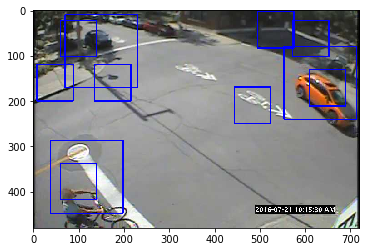

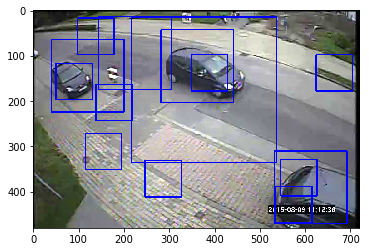

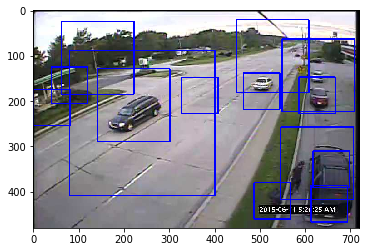

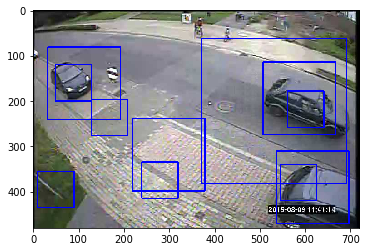

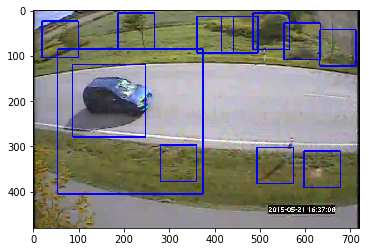

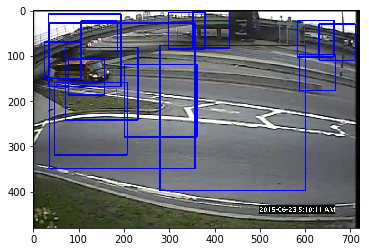

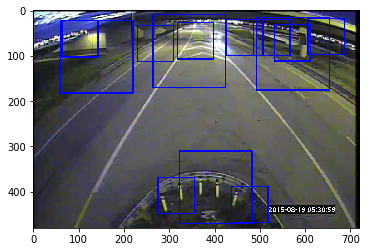

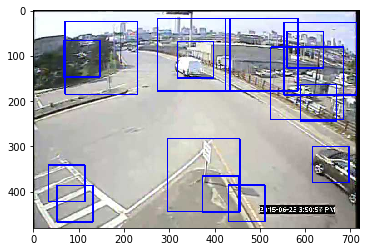

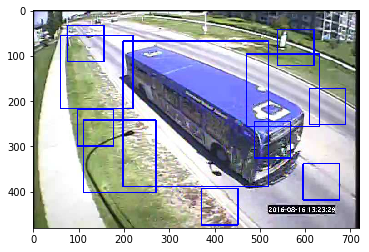

In [2]:
###### Localize the entire testing image set while showing a small sample of the result of Localization

car_cascade = cv2.CascadeClassifier('cascade.xml')


info=[] # hold a list of detected objects' information (x,y wt, ht)
for i in range(len(test_imgs)):
    
    # Localiza the entire testing image set using cascade.detectMultiScale
    cars = car_cascade.detectMultiScale(test_gray[i], 2, 3)

    info.append(cars)
    
    # Display the 10 samples of localization
    disp= test_imgs[i].copy()
    if i < 10:
        for (x,y,w,h) in cars:
            if(w*h)> 2000:
                cv2.rectangle(disp, (x,y), (x+w, y+h), (255,0,0), 2)

        plt.imshow(cv2.cvtColor(disp, cv2.COLOR_BGR2RGB))
        plt.show()
    



In [3]:
###### Obtain Groundtruth from csv file

# read csv file into truth table
import csv
truth_table = []
with open('test_images.csv') as file:
    reader = csv.reader(file)
    for row in reader:
        truth_table.append(row)




In [4]:
##### Computes TP 
def get_TP(a, b):

    #Coordinates the intersecting boxes
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    width = (x2 - x1)
    height = (y2 - y1)

    # When there is now overlap
    if (width<0) or (height <0):
        return 0.0
    TP = width * height
    return TP

In [5]:
###### Compute DICE Coefficients

dice_total = []  # will hold the dice between every localized objects to all the groundtruth objects
dice_index=  []  # will hold the information of relating to each localized object 

#compute and store each dice between each groundtruth object to all the localized objects in each image 
for i in range (len(truth_table)): # loop through each object in groundtruth
    
    # unpackage the information from groundtruth
    num_image = int(truth_table[i][0])
    num_image = num_image-3600
    label = truth_table[i][1]
    x1 = int(truth_table[i][2])  
    y1 = int(truth_table[i][3])
    x2 = int(truth_table[i][4])
    y2 = int(truth_table[i][5])
    
    dice_box =[]
    index_box=[]
    
    if len(info[num_image]) !=0:
        for k in range(len(info[num_image])):# loop through each localized objects in one image

            x3=info[num_image][k][0]
            y3=info[num_image][k][1]
            wt=info[num_image][k][2]
            ht=info[num_image][k][3]
            x4=x3+wt
            y4=y3+ht

            box1= [x1,y1,x2,y2]
            box2= [x3,y3,x4,y4]

            # dice computation between one groundtruth objects and one localized object
            TP = get_TP(box1, box2)
            FN = (abs(x1-x2)*abs(y1-y2))-TP
            FP = (wt*ht)-TP              
            dice = (2*TP)/((2*TP)+FP+FN)
            dice_box.append(dice)
            
            d_info=[num_image,label,x3,y3,wt,ht]
            index_box.append(d_info)
            
    else:
        dice_box.append(0)
        d_info=[num_image,label,0,0,20,20]
        index_box.append(d_info)
        
    dice_total.append(dice_box)
    dice_index.append(index_box)
    

    
    
dice_each=[]  # max of dice the localized objects for each ground truth label
snip_each=[]  # information need to snip the the max of dice the localized objects for each ground truth label



for i in range(len(dice_total)): #loop for each object in a pic
    dice_each.append(max(dice_total[i]))
    index=np.argmax(dice_total[i])
    snip_each.append(dice_index[i][index])


    


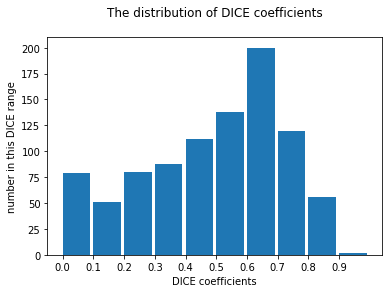

The mean of the DICE coefficients is 0.4938248796626687


In [6]:
##### Calculate and Plot the distribution of DICE coefficients



distribution = [0,0,0,0,0,0,0,0,0,0]

for i in range(10):
    for x in dice_each:
        if(x >= i/10 and x < i/10 + 0.1):
            distribution[i] = distribution[i]+1
            
xaxis = []
for i in range(10):
    xaxis.append(i/10)


plt.bar(xaxis,   distribution, width=0.09, align='edge') # A bar chart
plt.title("The distribution of DICE coefficients\n")
plt.xlabel('DICE coefficients')
plt.ylabel('number in this DICE range')
plt.xticks(np.arange(0, 1,0.1))
plt.show()

print('The mean of the DICE coefficients is',np.mean(dice_each))


### Prepare Label and image input for localization+classification

In [7]:
# write the label that will be read by Localization+classifcation file
with open ('corretLabels.csv','w',newline='') as f:
    writer=csv.writer(f)
    for i in range (len(snip_each)):
        writer.writerow([i,snip_each[i][1]])
        

In [8]:
# write the images that will be read by Localization+classificaiton file
for i in range (len(snip_each)):
    
    img_num = snip_each[i][0]
    x   = snip_each[i][2]
    y   = snip_each[i][3]
    wt  = snip_each[i][4]
    ht  = snip_each[i][5] 
    
    img      = test_imgs[img_num].copy()
    crop_img = img[y:y+ht, x:x+wt]
    cv2.imwrite('result_images/'+str(i)+'.jpg', crop_img)